<a href="https://colab.research.google.com/github/BrianvanWinden/TM10007_Group_13/blob/master/Code_opgeschoond_en_werkend_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing functions

In [7]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets as ds
from scipy.stats import randint
from zipfile import ZipFile
from scipy import stats
from statistics import stdev


# Classifiers and kernels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn import preprocessing, metrics
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

# Regularization
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.feature_selection import SelectFromModel

# Model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, learning_curve, ShuffleSplit, StratifiedKFold

from sklearn.pipeline import Pipeline

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Sampling
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.pipeline import make_pipeline



def evaluation(y_val, y_pred, title = 'Confusion Matrix'):
    cm = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    # print('Recall: ', recall)
    # print('Accuracy: ', accuracy)
    # print('Precision: ', precision)
    # print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    return plt


# Assignment arrhythmia classification

In [8]:
# Run this to use from colab environment
!git clone https://github.com/BrianvanWinden/TM10007_Group_13.git
!unzip "/content/TM10007_Group_13/ecg/ecg_data.zip"
import pandas as pd 

data = pd.read_csv("ecg_data.csv") 

data_points= data.drop(['label'], axis=1).to_numpy()
data_labels= data['label'].to_numpy()
x_train_val, x_test, y_train_val, y_test = train_test_split(data_points, data_labels, test_size=0.3, stratify=data_labels)

# print(data.head())

fatal: destination path 'TM10007_Group_13' already exists and is not an empty directory.
Archive:  /content/TM10007_Group_13/ecg/ecg_data.zip
replace ecg_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ecg_data.csv            


# Taking a look at the data

In [9]:
# Samples and features
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)}')
healthy_patients = (list(data['label'] == 0)).count(True)
print(f'The number of healthy patients: {healthy_patients}') 
sick_patients = (list(data['label'] == 1)).count(True)
print(f'The number of sick patients: {sick_patients}')
percentage_sick=sick_patients/(sick_patients+healthy_patients)
print(f'Percentage of sick patients: {round(percentage_sick,2)*100}%')

# Outliers # aanpassen
z = np.abs(stats.zscore(data))
x = np.where(z>3)
print(f'Number of datapoints where the Z score is larger than 3: {len(x[1])}')

# Missing values
missing_values = data.isna().sum()
number_missing_values = missing_values.astype(bool).sum(axis=0)
print(f'Number of missig data points:{number_missing_values}')




The number of samples: 827
The number of features: 9002
The number of healthy patients: 681
The number of sick patients: 146
Percentage of sick patients: 18.0%
Number of datapoints where the Z score is larger than 3: 57812
Number of missig data points:0


# Preprocessing and classifier validation

In [10]:
# Splitting data  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

cv_outer = StratifiedKFold(n_splits=5, shuffle=True)
cv_inner = StratifiedKFold(n_splits=3, shuffle=True)
outer_results = list()
all_scores = list()
models = list()

for train_ix, val_ix in cv_outer.split(x_train_val,y_train_val):
  # split data
  X_train, X_val = x_train_val[train_ix, :], x_train_val[val_ix, :]
  y_train, y_val = y_train_val[train_ix], y_train_val[val_ix]
  print (X_train.shape)
  print(X_val.shape)
  #Resampling
  # combines SMOTE over and edited nearest neighbour undersampling
  # edited nearest neighbours kan van beide groepen weghalen, met sampling_strategy='majority' alleen van grote groep
  # the authors comment that ENN is more aggressive at downsampling the majority class than Tomek Links, providing more in-depth cleaning. They apply the method, removing examples from both the majority and minority classes.
  #A Study of the Behavior of Several Methods for Balancing Machine Learning Training Data, 2004.
  resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
  X_resampled, y_resampled = resample.fit_resample(X_train, y_train)

  #Scaling
  scaler = preprocessing.RobustScaler()
  scaler.fit(X_resampled)
  x_train_scaled = scaler.transform(X_resampled)
  x_val_scaled = scaler.transform(X_val)

  #PCA
  pca = PCA(n_components=0.99)
  pca = pca.fit(x_train_scaled)
  x_train_trans = pca.transform(x_train_scaled)
  x_val_trans = pca.transform(x_val_scaled)
  print(x_train_trans)
  model_params = {'svm_rbf': 
                  {'model': SVC(kernel='rbf', class_weight='balanced'),
                    'params': {'C': [0.01, 0.5, 1, 10],
                               'gamma': [0.01, 1, 10]
                               }
                  },
                   'svm_lin': 
                  {'model': SVC(kernel='linear', class_weight='balanced'),
                    'params': {'C': [0.01, 0.5, 1, 10],
                               'gamma': [0.01, 1, 10]
                               }
                   },
                  'linsvc': 
                  {'model': LinearSVC(class_weight='balanced', dual=False, max_iter=10000),
                   'params':{'C': [0.01, 0.5, 1, 10]
                             }
                  },
                  'logreg':
                  {'model': LogisticRegression(class_weight='balanced', dual=False, max_iter=10000),
                   'params':{'C': [0.01, 0.5, 1, 10]
                             }                      
                  # },
                  # 'lda': 
                  # {'model': LinearDiscriminantAnalysis(),
                  # 'params':{}
                  # },
                  # 'knn':
                  # {'model': KNeighborsClassifier(weights='distance'),
                  #  'params':{'n_neighbors': [5,10,15]
                  #            }
                   }
                }

  for model_name, mp in model_params.items():
    search = GridSearchCV(mp['model'], mp['params'], cv = cv_inner, scoring = 'roc_auc', return_train_score=True)
    result = search.fit(x_train_scaled, y_resampled)
    best_model = result.best_estimator_
    models.append(best_model)
    yhat = best_model.predict(x_val_scaled)
    auc_score_val = roc_auc_score(y_val, yhat)
    outer_results.append(auc_score_val)
    all_scores.append(result.best_score_)
    print(f'auc: {auc_score_val}, result.best_score_:{result.best_score_}, best parameters:{result.best_params_}')



(462, 9001)
(116, 9001)
[[ 2.15920935e+01  1.34121650e+01  7.66595592e+01 ... -1.51871581e+00
   1.34887332e+00  2.52165697e+00]
 [ 2.06435322e+01 -4.19192818e+01  5.59275891e+00 ... -5.55446041e+00
  -7.26308126e+00  1.66866729e+00]
 [-3.69732322e+01  6.18595858e+00 -1.25150397e+01 ... -4.47198451e-01
  -1.22675480e+01 -2.96339136e+00]
 ...
 [-2.89966709e+01  9.48644783e+00 -1.40455517e+01 ...  1.84805166e-01
  -1.38680360e-01 -4.82664945e-01]
 [-3.48636078e+01  5.63689115e+00 -1.19964028e+01 ...  3.05975525e-01
  -2.74645631e-01  1.32338179e-01]
 [-4.88670178e+01  1.88839218e+00 -1.88571346e+01 ... -1.08156431e-01
   1.09157718e+00 -1.96436581e-03]]
auc: 0.5, result.best_score_:0.9337051822770519, best parameters:{'C': 0.5, 'gamma': 0.01}
auc: 0.7364583333333332, result.best_score_:0.958412878128796, best parameters:{'C': 0.01, 'gamma': 0.01}
auc: 0.6916666666666667, result.best_score_:0.9597542137298197, best parameters:{'C': 0.5}
auc: 0.746875, result.best_score_:0.9687240892274086

# Best classifier for test set

                                               Models  Auc score  Best score
3   LogisticRegression(C=0.01, class_weight='balan...   0.746875    0.968724
6   LinearSVC(C=0.01, class_weight='balanced', dua...   0.746366    0.944938
1   SVC(C=0.01, break_ties=False, cache_size=200, ...   0.736458    0.958413
9   SVC(C=0.01, break_ties=False, cache_size=200, ...   0.735840    0.971723
11  LogisticRegression(C=10, class_weight='balance...   0.712030    0.975487
10  LinearSVC(C=0.01, class_weight='balanced', dua...   0.704010    0.965186
7   LogisticRegression(C=1, class_weight='balanced...   0.701504    0.963646
2   LinearSVC(C=0.5, class_weight='balanced', dual...   0.691667    0.959754
18  LinearSVC(C=0.01, class_weight='balanced', dua...   0.688158    0.978332
5   SVC(C=0.01, break_ties=False, cache_size=200, ...   0.682957    0.977271
17  SVC(C=0.01, break_ties=False, cache_size=200, ...   0.682895    0.978048
19  LogisticRegression(C=10, class_weight='balance...   0.647368    0.977729

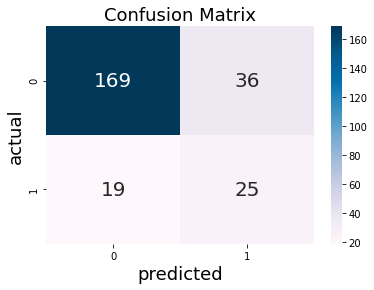

In [11]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

models_df = pd.DataFrame(models)
outer_results_df = pd.DataFrame(outer_results)
all_scores_df = pd.DataFrame(all_scores)
results = pd.concat([models_df, outer_results_df, all_scores_df], axis=1)
results.columns = ['Models', 'Auc score', 'Best score']
results_sorted = results.sort_values(by=['Auc score'], ascending=False)
print(results_sorted)

best_classifier = results_sorted['Models'].iloc[0]
print(f'The best classifier is: {best_classifier}')

# cv_test = StratifiedKFold(n_splits=2, shuffle=True)
# # ('resampling', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),('scaling', preprocessing.RobustScaler()),('pca', PCA(n_components=0.99)),
# clf = Pipeline([('pca', PCA(n_components=0.99)), ('clf', best_classifier)])
# cross_score = cross_val_score(clf, x_test, y_test, cv=cv_test, scoring='roc_auc')
# print(f'Mean score of classifier on test data: {round(mean(cross_score),3)} + {round(stdev(cross_score),3)}')

#Resampling
resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_resampled, y_resampled = resample.fit_resample(x_train_val, y_train_val)

#Scaling
scaler = preprocessing.RobustScaler()
scaler.fit(X_resampled)
x_train_scaled = scaler.transform(X_resampled)
x_test_scaled = scaler.transform(x_test)

#PCA
pca = PCA(n_components=0.99)
pca = pca.fit(x_train_scaled)
x_train_trans = pca.transform(x_train_scaled)
x_test_trans = pca.transform(x_test_scaled)

# Evaluation classifier
clf = best_classifier.fit(x_train_trans, y_resampled)
y_pred = clf.predict(x_test_trans)
accuracy = metrics.balanced_accuracy_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
print('Misclassified: %d / %d' % ((y_test != y_pred).sum(), x_test_trans.shape[0]), str(clf))
evaluation(y_test, y_pred)

print(f'Auc score test data: {auc}')


# Leanring curves

TypeError: ignored

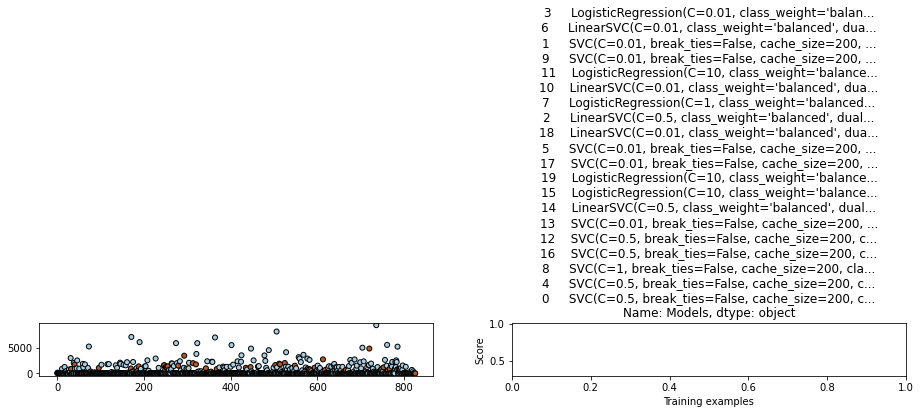

In [12]:
# Learning Curve

X = data_points
Y = data_labels

clsfs = [results_sorted['Models']]

num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
ax = fig.add_subplot(7, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y, 
           s=25, edgecolor='k', cmap=plt.cm.Paired)

cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
num = 1
for clf in clsfs:
    # Split data in training and testing
    title = str(clf)
    ax = fig.add_subplot(7, 3, num + 1)
    plot_learning_curve(clf, title, X, Y, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1